In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

In [2]:
# Import helper functions
sys.path.append('..')
from src.analysis_utils import *

# Configuration
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

In [12]:
# File paths
DATA_DIR = Path("../data/")
DEAM_CORE_PATH = DATA_DIR / "processed/DEAM/deam_core.csv"
DEAM_CORE_PATH_LYRICS = DATA_DIR / "processed/DEAM/deam_core_with_lyrics.csv"
LYRICS_CACHE_PATH = DATA_DIR / "processed/DEAM/lyrics_cache.json"
DF_HIGH_PATH = DATA_DIR / "processed_features/DEAM/df_high.parquet"
DF_MID_PATH = DATA_DIR / "processed_features/DEAM/df_mid.parquet"
DF_LOW_PATH = DATA_DIR / "processed_features/DEAM/df_low.parquet"

### DATA LOADING AND BASIC STATISTICS

In [15]:
# Load core dataset with lyrics
df_core = pd.read_csv(DEAM_CORE_PATH_LYRICS)

print(f"Dataset shape: {df_core.shape}")
print(f"Columns: {list(df_core.columns)}")
print(f"\nFirst 5 rows:")
print(df_core.head())

print(f"\nDataset info:")
print(df_core.info())

Dataset shape: (1744, 8)
Columns: ['song_id', 'track_name', 'artist_name', 'valence_mean', 'arousal_mean', 'valence_std', 'arousal_std', 'lyrics']

First 5 rows:
   song_id                track_name                   artist_name  \
0        2  Tonight A Lonely Century  The New Mystikal Troubadours   
1        3                 DD Groove                 Kevin MacLeod   
2        4                 Slow Burn                 Kevin MacLeod   
3        5              Nothing Much                 My Bubba & Mi   
4        7                    Hustle                 Kevin MacLeod   

   valence_mean  arousal_mean  valence_std  arousal_std lyrics  
0           3.1           3.0         0.94         0.63    NaN  
1           3.5           3.3         1.75         1.62    NaN  
2           5.7           5.5         1.42         1.63    NaN  
3           4.4           5.3         2.01         1.85    NaN  
4           5.8           6.4         1.47         1.69    NaN  

Dataset info:
<class 'pand

In [16]:
# Load lyrics cache for comparison
import json
with open(LYRICS_CACHE_PATH, 'r', encoding='utf-8') as f:
    lyrics_cache = json.load(f)

# Lyrics statistics
csv_valid_lyrics = df_core['lyrics'].apply(lambda x: isinstance(x, str) and x.strip() != "").sum()
json_valid_lyrics = sum(isinstance(v, str) and v.strip() != "" for v in lyrics_cache.values())

print("Lyrics availability:")
print(f"Valid lyrics in CSV: {csv_valid_lyrics}")
print(f"Valid lyrics in cache: {json_valid_lyrics}")

Lyrics availability:
Valid lyrics in CSV: 237
Valid lyrics in cache: 237


In [17]:
# Basic emotion statistics
emotion_cols = ['valence_mean', 'valence_std', 'arousal_mean', 'arousal_std']
print(f"\nEmotion metrics summary:")
print(df_core[emotion_cols].describe())


Emotion metrics summary:
       valence_mean  valence_std  arousal_mean  arousal_std
count   1744.000000  1744.000000   1744.000000  1744.000000
mean       4.903492     1.521950      4.812603     1.466778
std        1.173920     0.385496      1.289368     0.367197
min        1.600000     0.300000      1.600000     0.460000
25%        4.100000     1.270000      3.800000     1.200000
50%        4.900000     1.510000      4.900000     1.480000
75%        5.800000     1.780000      5.800000     1.720000
max        8.400000     2.900000      8.100000     2.590000


In [18]:
# Quick statistical overview
print(f"\nValence/Arousal ranges:")
for col in ['valence_mean', 'arousal_mean']:
    values = df_core[col].dropna()
    print(f"  {col}: {values.min():.2f} to {values.max():.2f} "
          f"(mean: {values.mean():.2f}, std: {values.std():.2f})")


Valence/Arousal ranges:
  valence_mean: 1.60 to 8.40 (mean: 4.90, std: 1.17)
  arousal_mean: 1.60 to 8.10 (mean: 4.81, std: 1.29)


### EMOTION DISTRIBUTION ANALYSIS

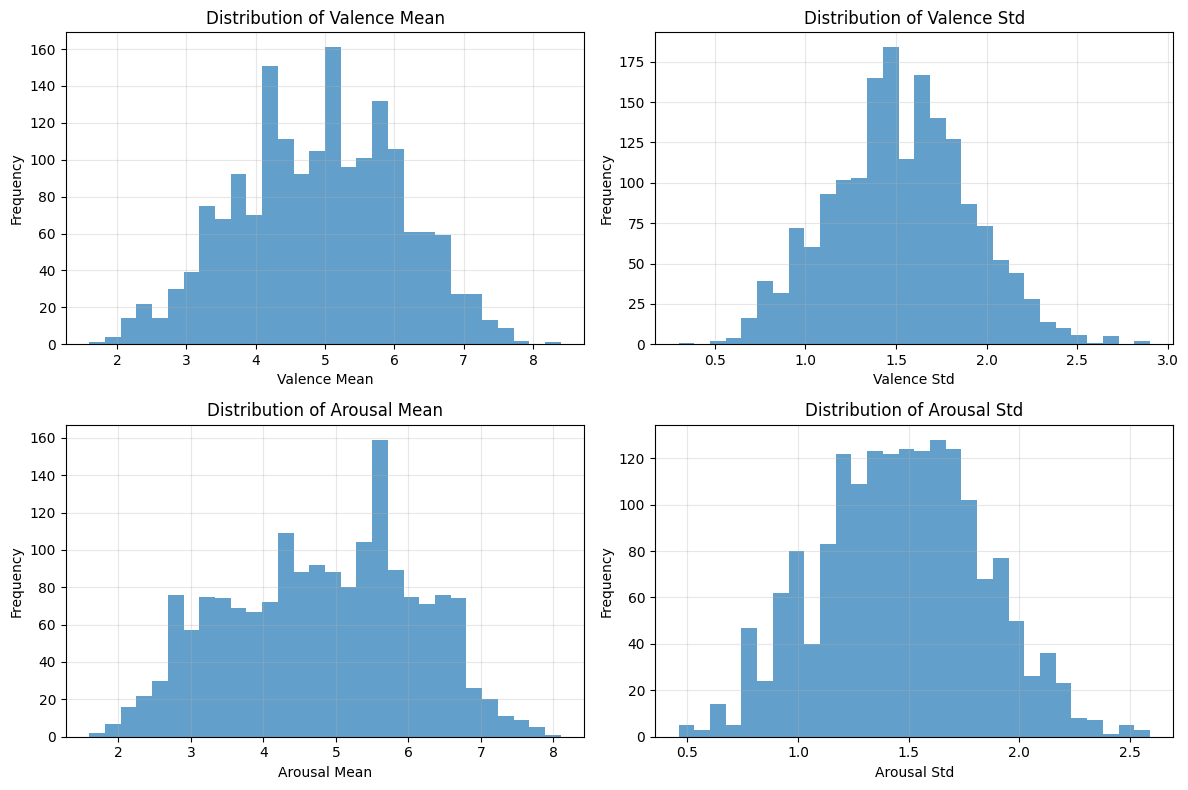

In [19]:
# Plot emotion distributions
plot_emotion_distributions(df_core)

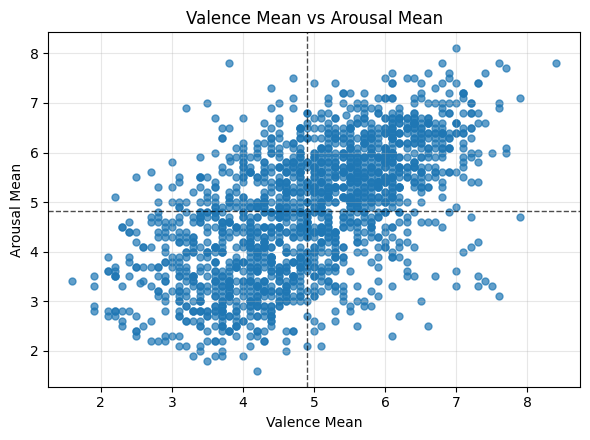

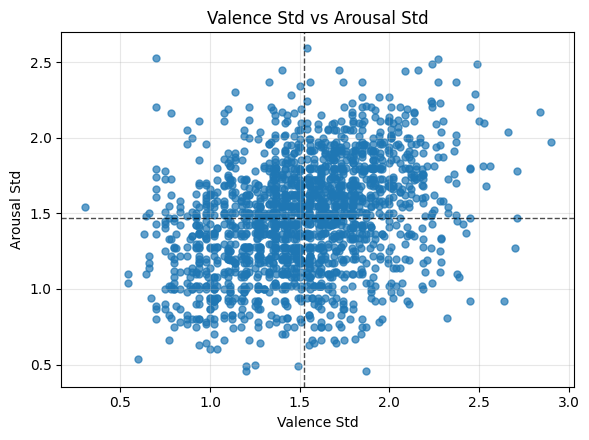

In [20]:
# Scatter plots for emotion relationships
plot_emotion_scatter(df_core, 'mean')
plot_emotion_scatter(df_core, 'std')

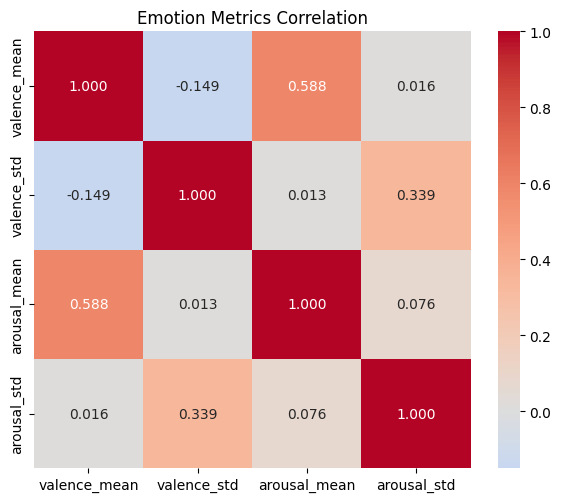

In [21]:
# Emotion correlation
emotion_corr = df_core[emotion_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(emotion_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Emotion Metrics Correlation')
plt.tight_layout()
plt.show()

### HIGH-LEVEL FEATURE ANALYSIS

Analyzing key-mode relationships...


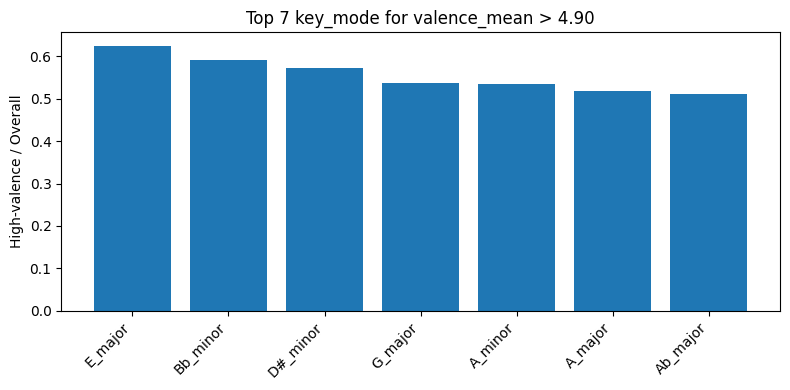

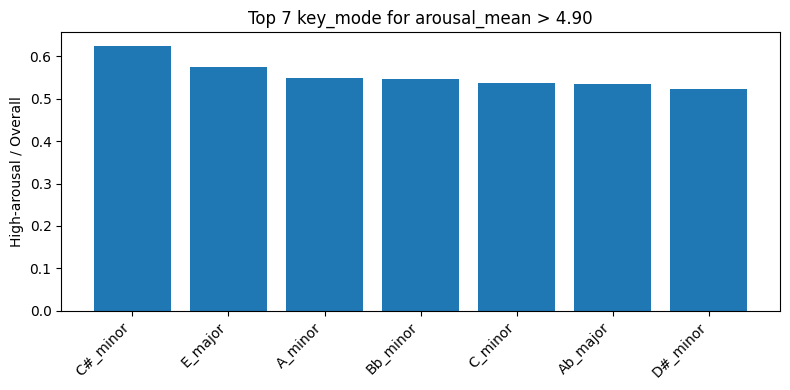

Analyzing BPM relationships...


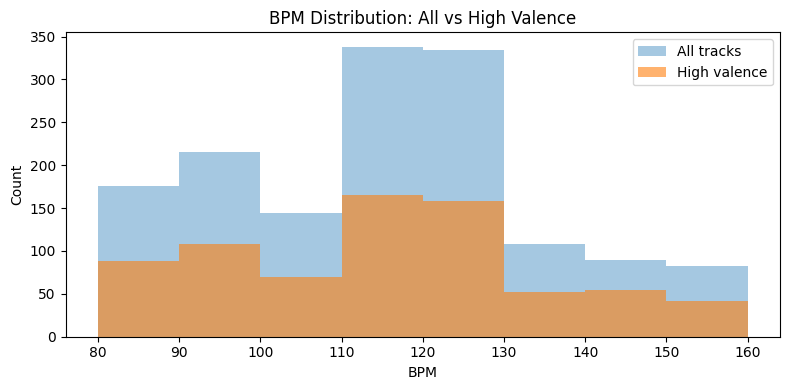

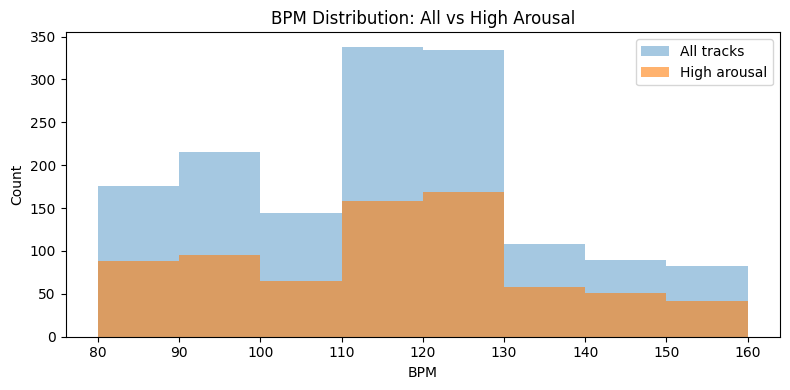

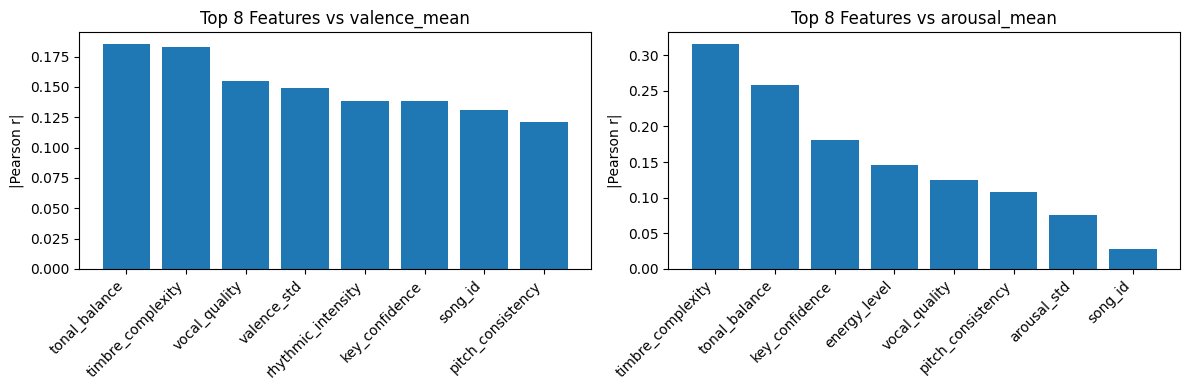

In [22]:
# Load high-level features
df_high = load_and_prepare_data(DF_HIGH_PATH)
    
# Key-mode analysis
print(f"Analyzing key-mode relationships...")
plot_feature_emotion_analysis(df_high, 'key_mode', 'valence_mean')
plot_feature_emotion_analysis(df_high, 'key_mode', 'arousal_mean')
    
# BPM analysis
print(f"Analyzing BPM relationships...")
plot_bpm_comparison(df_high, 'valence_mean')
plot_bpm_comparison(df_high, 'arousal_mean')
    
# Feature correlations
correlations = get_feature_correlations(df_high)
plot_top_correlations(correlations, top_n=8)

### MULTI-LEVEL FEATURE ANALYSIS

Found 4 timbre features


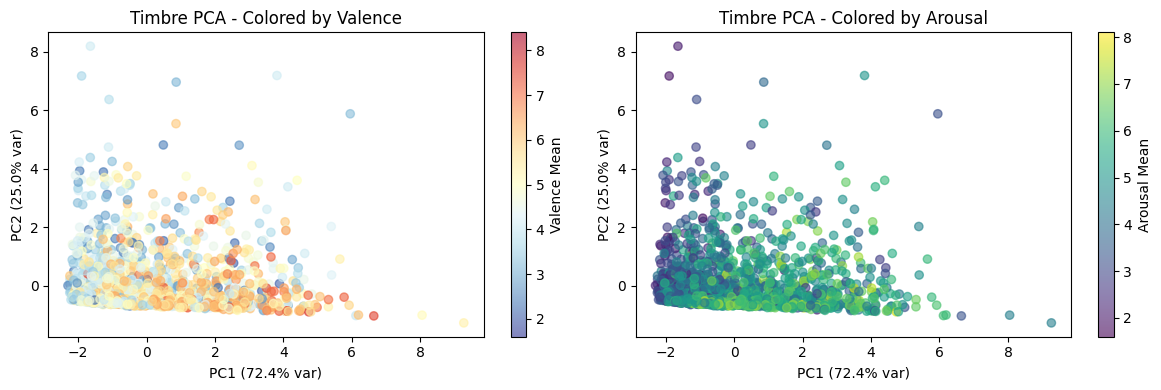

PCA explained variance: [0.72408027 0.24971164]


In [23]:
# Combine high and mid-level features
df_combined = load_and_prepare_data(DF_HIGH_PATH, DF_MID_PATH)
    
# Timbre analysis
timbre_features = [col for col in df_combined.columns 
                      if 'timbre' in col.lower()]
    
if timbre_features:
    print(f"Found {len(timbre_features)} timbre features")
        
    # Timbre PCA analysis
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
        
    df_timbre = df_combined[timbre_features + ['valence_mean', 'arousal_mean']].dropna()
        
    # Standardize and apply PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_timbre[timbre_features])
        
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)
        
    # Plot PCA results
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
    # Valence coloring
    scatter1 = axes[0].scatter(pcs[:, 0], pcs[:, 1], 
                                  c=df_timbre['valence_mean'], 
                                  alpha=0.6, cmap='RdYlBu_r')
    axes[0].set_title('Timbre PCA - Colored by Valence')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    plt.colorbar(scatter1, ax=axes[0], label='Valence Mean')
        
    # Arousal coloring  
    scatter2 = axes[1].scatter(pcs[:, 0], pcs[:, 1], 
                                  c=df_timbre['arousal_mean'], 
                                  alpha=0.6, cmap='viridis')
    axes[1].set_title('Timbre PCA - Colored by Arousal')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    plt.colorbar(scatter2, ax=axes[1], label='Arousal Mean')
        
    plt.tight_layout()
    plt.show()
        
    print(f"PCA explained variance: {pca.explained_variance_ratio_}")

### STATISTICAL ANALYSIS

In [24]:
df_stats = pd.read_parquet(DF_HIGH_PATH)
    
# Correlation analysis
from scipy.stats import spearmanr, f_oneway
    
# BPM vs emotions
clean_data = df_stats[['bpm', 'valence_mean', 'arousal_mean']].dropna()
    
if len(clean_data) > 10:  # Ensure enough data
    rho_val, p_val = spearmanr(clean_data['bpm'], clean_data['valence_mean'])
    rho_aro, p_aro = spearmanr(clean_data['bpm'], clean_data['arousal_mean'])
        
    print(f"BPM correlations:")
    print(f"  BPM vs Valence: ρ={rho_val:.3f}, p={p_val:.3f}")
    print(f"  BPM vs Arousal: ρ={rho_aro:.3f}, p={p_aro:.3f}")
    
# Key-mode ANOVA
if 'key_mode' in df_stats.columns:
    top_modes = df_stats['key_mode'].value_counts().head(5).index
    groups = [df_stats[df_stats['key_mode'] == mode]['valence_mean'].dropna() 
                 for mode in top_modes]
        
    if all(len(g) > 0 for g in groups):
        F_stat, p_val = f_oneway(*groups)
        print(f"Key-mode ANOVA (valence): F={F_stat:.2f}, p={p_val:.3f}")

BPM correlations:
  BPM vs Valence: ρ=-0.005, p=0.833
  BPM vs Arousal: ρ=0.022, p=0.403


### SUMMARY AND INSIGHTS

In [25]:
df_summary = pd.read_parquet(DF_HIGH_PATH)
    
print(f"Total songs analyzed: {len(df_summary)}")
print(f"Valence range: {df_summary['valence_mean'].min():.2f} - {df_summary['valence_mean'].max():.2f}")
print(f"Arousal range: {df_summary['arousal_mean'].min():.2f} - {df_summary['arousal_mean'].max():.2f}")
    
# Top correlations summary
if 'correlations' in locals():
    print(f"\nTop valence predictors:")
    for feature, corr in correlations['valence_mean'].head(3).items():
        print(f"  {feature}: r={corr:.3f}")
        
    print(f"\nTop arousal predictors:")  
    for feature, corr in correlations['arousal_mean'].head(3).items():
        print(f"  {feature}: r={corr:.3f}")

Total songs analyzed: 1744
Valence range: 1.60 - 8.40
Arousal range: 1.60 - 8.10

Top valence predictors:
  tonal_balance: r=0.186
  timbre_complexity: r=0.183
  vocal_quality: r=0.155

Top arousal predictors:
  timbre_complexity: r=0.316
  tonal_balance: r=0.258
  key_confidence: r=0.181


/tmp/ipykernel_607/766980068.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


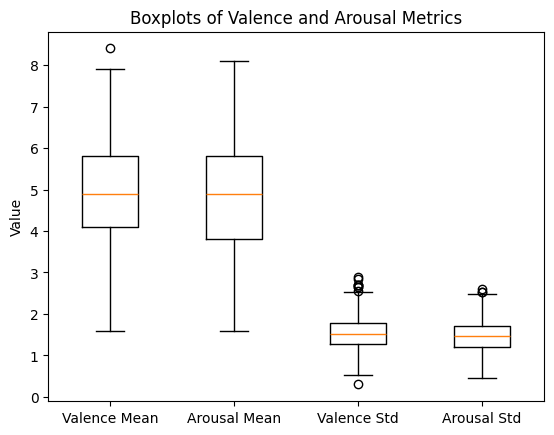

In [57]:
# Boxplot of all metrics
plt.figure()
plt.boxplot([
    df['valence_mean'].dropna(),
    df['arousal_mean'].dropna(),
    df['valence_std'].dropna(),
    df['arousal_std'].dropna()
], labels=['Valence Mean', 'Arousal Mean', 'Valence Std', 'Arousal Std'])
plt.title('Boxplots of Valence and Arousal Metrics')
plt.ylabel('Value')

plt.show()

In [58]:
high_valence_sample = df[df['valence_mean'] > 8]

In [59]:
print(high_valence_sample)

    song_id   track_name                         artist_name  valence_mean  \
89      115  Bip Bop Bip  Barrence Whitfield and The Savages           8.4   

    arousal_mean  valence_std  arousal_std lyrics  
89           7.8         0.66         1.17    NaN  


In [60]:
val_std_mid = df['valence_std'].mean()
arous_std_mid = df['arousal_std'].mean()
print(val_std_mid)
print(arous_std_mid)

1.5219495412844037
1.46677752293578


In [61]:
high_valence_std = df[df['valence_std'] > val_std_mid+1.]
high_arousal_std = df[df['arousal_std'] > arous_std_mid+1.]

In [62]:
print(high_valence_std)

      song_id                   track_name              artist_name  \
111       138  Encounters With Abusive Men           Silver Process   
129       159      Awaken From A Nightmare           Silver Process   
212       246          Traumatic Childhood           Silver Process   
377       456                Crack in Time              Stickfigure   
798      1055                    Sexy Lady           Break The Bans   
802      1059          Green Turning Light          Sound Of Ground   
911      1168                        piano           Corey Cerovsek   
1077     1334                         Eyes            I Have Clones   
1437     1694       Only The Wrong Survive                   Vialka   
1710     1967                   Black Hole  Mike Rep and the Quotas   

      valence_mean  arousal_mean  valence_std  arousal_std lyrics  
111            3.8           2.4         2.64         0.92    NaN  
129            3.8           3.1         2.56         1.81    NaN  
212           

In [63]:
print(high_arousal_std)

      song_id                                         track_name  \
16         25                                        RL Got Soul   
329       387  Memories Of Thailand (Beat Doctor's 'stuck in ...   
797      1054                                              Lover   
1692     1949                                                 II   
1712     1969                                            Vietnam   

                          artist_name  valence_mean  arousal_mean  \
16    The Jon Spencer Blues Explosion           7.9           4.7   
329                             Risey           6.2           6.2   
797                    Break The Bans           3.7           6.3   
1692                Angels in America           2.2           5.1   
1712   Here Comes A Big Black Cloud!!           3.7           5.7   

      valence_std  arousal_std  \
16           0.70         2.53   
329          2.27         2.52   
797          2.49         2.49   
1692         1.54         2.59   
1712  

In [64]:
import pandas as pd
import os

# Load all metadata CSVs
metadata_dir = 'metadata_DEAM/metadata'
metadata_files = [f for f in os.listdir(metadata_dir) if f.endswith('.csv')]

metadata_list = [pd.read_csv(os.path.join(metadata_dir, f)) for f in metadata_files]

# concatenate them into one DataFrame
metadata_df = pd.concat(metadata_list, ignore_index=True)

# Merge with the original df on song_id
merged_df = df.merge(metadata_df, on='song_id', how='left')  # left join to keep only matching rows

# Filter for valence std higher than mean + 1
high_valence_std_tracks = merged_df[merged_df['valence_std'] > val_std_mid+1.]

# Step 5: Show song_id and genre(s)
print(high_valence_std_tracks[['song_id', 'Genre']])

high_arousal_std_tracks = merged_df[merged_df['arousal_std'] > arous_std_mid+1.]

print(high_arousal_std_tracks[['song_id', 'Genre']])

      song_id                                 Genre
111       138                         \tClassical\t
129       159                         \tClassical\t
212       246                         \tClassical\t
377       456                        \tElectronic\t
798      1055                     SoulRB-Blues-Rock
802      1059                     SoulRB-Blues-Rock
911      1168                             Classical
1077     1334                            Electronic
1437     1694  International-Folk-Experimental-Rock
1710     1967                                  Rock
      song_id              Genre
16         25          \tBlues\t
329       387     \tElectronic\t
797      1054  SoulRB-Blues-Rock
1692     1949               Rock
1712     1969               Rock


In [65]:
# no significant correlation with genres observed, next suspicion is key/mode

In [66]:
high_level_path = 'df_high.parquet'
high_level = pd.read_parquet(high_level_path)

high_valence_key_tracks = high_level[high_level['valence_std'] > val_std_mid]

high_arousal_key_tracks = high_level[high_level['arousal_std'] > arous_std_mid]

In [67]:
print('High Valence std tracks')
print('#######################################################################')
print(high_valence_key_tracks.head())
print('#######################################################################')
print('High Arousal std tracks')
print('#######################################################################')
print(high_arousal_key_tracks.head())

High Valence std tracks
#######################################################################
   song_id                 track_name       artist_name  valence_mean  \
1        3                  DD Groove     Kevin MacLeod           3.5   
3        5               Nothing Much     My Bubba & Mi           4.4   
6       10               Stormy Blues  Arne Bang Huseby           4.0   
7       12                Rebel Blues         Sul Rebel           5.5   
9       17  Fjcb Reddit Gtr Fills Mix          Phoephus           4.4   

   arousal_mean  valence_std  arousal_std lyrics  pitch_consistency  \
1           3.3         1.75         1.62   None          18.389873   
3           5.3         2.01         1.85   None          40.401716   
6           4.7         1.67         1.85   None          65.729248   
7           5.8         1.91         1.89   None          29.522105   
9           6.0         1.80         2.05   None          31.933320   

   vocal_quality  timbre_complexity  e

In [68]:
# Add key_mode to full dataset
high_level['key_mode'] = high_level['key'].astype(str) + '_' + high_level['mode'].astype(str)

# Re-filter high valence tracks to include the new column
for high_std in [val_std_mid, val_std_mid + 0.5, val_std_mid +1.]:
    high_valence_key_tracks = high_level[high_level['valence_std'] > high_std]
    
    # Frequency in high valence subset
    high_freq = high_valence_key_tracks['key_mode'].value_counts()
    
    # Frequency in entire dataset
    total_freq = high_level['key_mode'].value_counts()
    
    # Normalize
    normalized_ratio = (high_freq / total_freq).sort_values(ascending=False)
    
    # Top 3 key+mode combinations, normalized
    top_3_normalized = normalized_ratio.head(3)
    
    print("Top 3 normalized key+mode combinations:")
    print(top_3_normalized)

Top 3 normalized key+mode combinations:
key_mode
C_minor     0.591398
G_minor     0.569620
Db_major    0.538462
Name: count, dtype: float64
Top 3 normalized key+mode combinations:
key_mode
C#_minor    0.156250
G#_minor    0.153846
Db_major    0.153846
Name: count, dtype: float64
Top 3 normalized key+mode combinations:
key_mode
Bb_major    0.046512
B_minor     0.034483
F#_minor    0.024390
Name: count, dtype: float64


In [69]:
# no major correlation to the key; for mode, minor seems to appear more often

In [70]:
for high_std in [arous_std_mid, arous_std_mid + 0.5, arous_std_mid + 1.0]:
    high_arousal_tracks = high_level[high_level['arousal_std'] > high_std]
    
    # Frequency in high-arousal subset
    high_freq = high_arousal_tracks['key_mode'].value_counts()
    
    # Frequency in entire dataset
    total_freq = high_level['key_mode'].value_counts()
    
    # Normalize
    normalized_ratio = (high_freq / total_freq).sort_values(ascending=False)
    
    # Top 3 key+mode combinations
    top_3_normalized = normalized_ratio.head(3)
    
    print(f"\nTop 3 normalized key+mode combinations for arousal_std > {high_std:.2f}:")
    print(top_3_normalized)


Top 3 normalized key+mode combinations for arousal_std > 1.47:
key_mode
D#_minor    0.642857
F#_major    0.595238
Db_major    0.576923
Name: count, dtype: float64

Top 3 normalized key+mode combinations for arousal_std > 1.97:
key_mode
Bb_minor    0.159091
E_minor     0.130081
Eb_major    0.121951
Name: count, dtype: float64

Top 3 normalized key+mode combinations for arousal_std > 2.47:
key_mode
G_minor     0.025316
Bb_minor    0.022727
E_minor     0.016260
Name: count, dtype: float64


In [71]:
# BPM focused analysis to find correlations

In [72]:
# Bin the bpm column (into 10 BPM-wide bins)
bins = range(int(high_level['bpm'].min()), int(high_level['bpm'].max()) + 10, 10)
high_level['bpm_bin'] = pd.cut(high_level['bpm'], bins)

# Re-filter to include new column
for threshold in [0, 0.5, 1.]:
    valence_threshold_bpm = val_std_mid + threshold
    high_valence_bpm_tracks = high_level[high_level['valence_std'] > valence_threshold_bpm]
    
    # Count bpm bin frequencies
    high_val_freq = high_valence_bpm_tracks['bpm_bin'].value_counts()
    total_freq = high_level['bpm_bin'].value_counts()
    
    # Normalize
    normalized_bpm_ratio = (high_val_freq / total_freq).sort_values(ascending=False)
    
    # Top 3 bpm bins
    top_3_bpm_bins = normalized_bpm_ratio.head(3)
    
    print("Top 3 normalized BPM bins (high valence adjusted):")
    print(top_3_bpm_bins)

Top 3 normalized BPM bins (high valence adjusted):
bpm_bin
(150, 160]    0.524390
(110, 120]    0.508876
(120, 130]    0.502994
Name: count, dtype: float64
Top 3 normalized BPM bins (high valence adjusted):
bpm_bin
(100, 110]    0.118056
(120, 130]    0.113772
(110, 120]    0.106509
Name: count, dtype: float64
Top 3 normalized BPM bins (high valence adjusted):
bpm_bin
(100, 110]    0.027778
(90, 100]     0.009302
(120, 130]    0.002994
Name: count, dtype: float64


In [73]:
bins = range(int(high_level['bpm'].min()), int(high_level['bpm'].max()) + 10, 10)
high_level['bpm_bin'] = pd.cut(high_level['bpm'], bins)

# Filter high-arousal tracks
for threshold in [0, 0.5, 1.]:
    arousal_threshold_bpm = arous_std_mid + threshold
    high_arousal_bpm_tracks = high_level[high_level['arousal_std'] > arousal_threshold_bpm]
    
    # Count frequencies per bpm_bin
    high_arousal_freq = high_arousal_bpm_tracks['bpm_bin'].value_counts()
    total_freq = high_level['bpm_bin'].value_counts()
    
    # Normalize
    normalized_bpm_ratio = (high_arousal_freq / total_freq).sort_values(ascending=False)
    
    # Top 3 bpm bins
    top_3_bpm_bins = normalized_bpm_ratio.head(3)
    
    print("Top 3 normalized BPM bins (high arousal adjusted):")
    print(top_3_bpm_bins)

Top 3 normalized BPM bins (high arousal adjusted):
bpm_bin
(120, 130]    0.556886
(100, 110]    0.541667
(150, 160]    0.536585
Name: count, dtype: float64
Top 3 normalized BPM bins (high arousal adjusted):
bpm_bin
(120, 130]    0.119760
(130, 140]    0.111111
(80, 90]      0.079545
Name: count, dtype: float64
Top 3 normalized BPM bins (high arousal adjusted):
bpm_bin
(120, 130]    0.005988
(80, 90]      0.005682
(110, 120]    0.002959
Name: count, dtype: float64


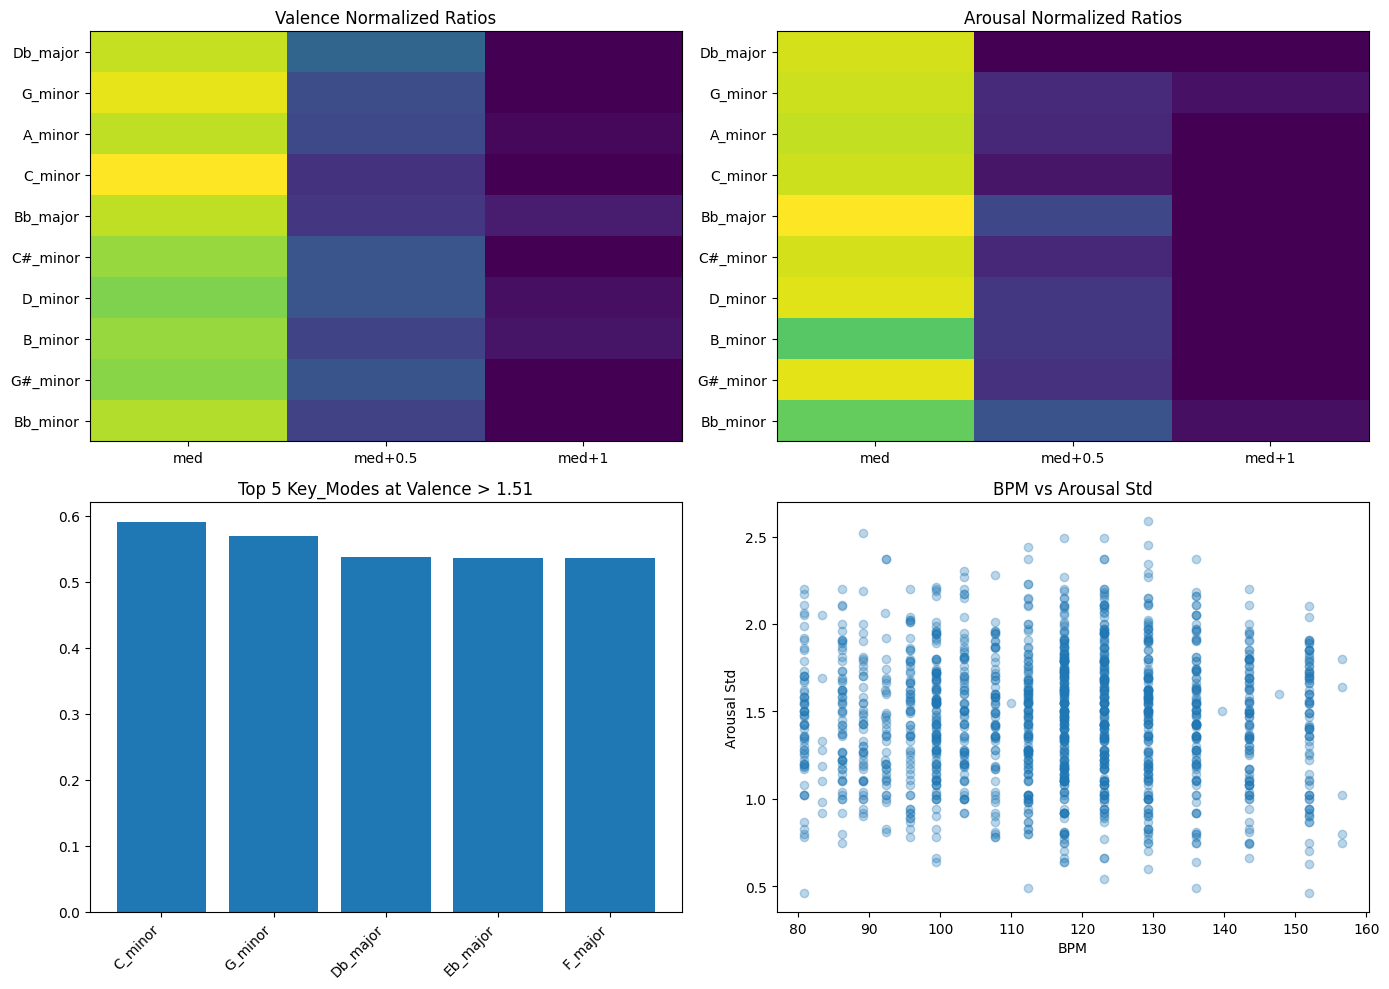

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
high_level = pd.read_parquet('df_high.parquet')

# Precompute key_mode column
high_level['key_mode'] = high_level['key'].astype(str) + '_' + high_level['mode'].astype(str)

# Compute thresholds
val_med = high_level['valence_std'].median()
aro_med = high_level['arousal_std'].median()
val_thresholds = [val_med, val_med + 0.5, val_med + 1.0]
aro_thresholds = [aro_med, aro_med + 0.5, aro_med + 1.0]

# Total occurrence of each key_mode
total_freq = high_level['key_mode'].value_counts()

# Build a DataFrame of normalized ratios
ratios = pd.DataFrame(index=total_freq.index)

# Valence columns
for thr in val_thresholds:
    col_name = f'val_{thr:.2f}'
    freq_high = high_level[high_level['valence_std'] > thr]['key_mode'].value_counts()
    ratios[col_name] = (freq_high / total_freq).fillna(0)

# Arousal columns
for thr in aro_thresholds:
    col_name = f'aro_{thr:.2f}'
    freq_high = high_level[high_level['arousal_std'] > thr]['key_mode'].value_counts()
    ratios[col_name] = (freq_high / total_freq).fillna(0)

# Select top 10 key_mode by mean valence ratio for heatmap readability
top_modes = ratios[[f'val_{val_med:.2f}', f'val_{val_med+0.5:.2f}', f'val_{val_med+1.0:.2f}']]\
    .mean(axis=1).sort_values(ascending=False).head(10).index
ratios_top = ratios.loc[top_modes]

# Create figure with 2x2 panels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: Valence heatmap
axes[0, 0].imshow(ratios_top[[f'val_{val_med:.2f}', f'val_{val_med+0.5:.2f}', f'val_{val_med+1.0:.2f}']].values, aspect='auto')
axes[0, 0].set_yticks(range(len(ratios_top)))
axes[0, 0].set_yticklabels(ratios_top.index)
axes[0, 0].set_xticks([0, 1, 2])
axes[0, 0].set_xticklabels(['med', 'med+0.5', 'med+1'])
axes[0, 0].set_title('Valence Normalized Ratios')

# Panel B: Arousal heatmap
axes[0, 1].imshow(ratios_top[[f'aro_{aro_med:.2f}', f'aro_{aro_med+0.5:.2f}', f'aro_{aro_med+1.0:.2f}']].values, aspect='auto')
axes[0, 1].set_yticks(range(len(ratios_top)))
axes[0, 1].set_yticklabels(ratios_top.index)
axes[0, 1].set_xticks([0, 1, 2])
axes[0, 1].set_xticklabels(['med', 'med+0.5', 'med+1'])
axes[0, 1].set_title('Arousal Normalized Ratios')

# Panel C: Top 5 key_modes by valence > median
top5_val = ratios[f'val_{val_med:.2f}'].sort_values(ascending=False).head(5)
axes[1, 0].bar(range(len(top5_val)), top5_val)
axes[1, 0].set_xticks(range(len(top5_val)))
axes[1, 0].set_xticklabels(top5_val.index, rotation=45, ha='right')
axes[1, 0].set_title(f'Top 5 Key_Modes at Valence > {val_med:.2f}')

# Panel D: BPM vs Arousal Std scatter
axes[1, 1].scatter(high_level['bpm'], high_level['arousal_std'], alpha=0.3)
axes[1, 1].set_xlabel('BPM')
axes[1, 1].set_ylabel('Arousal Std')
axes[1, 1].set_title('BPM vs Arousal Std')

plt.tight_layout()
plt.show()

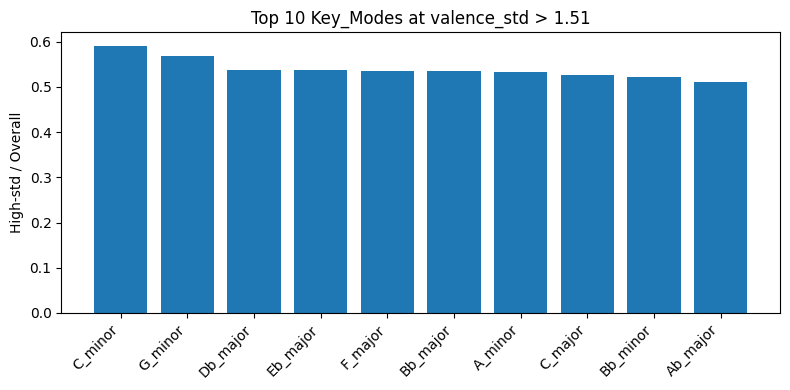

In [75]:
import matplotlib.pyplot as plt

# choose threshold
thr = high_level['valence_std'].median()

# compute normalized ratio
freq_high = high_level[high_level['valence_std']>thr]['key_mode'].value_counts()
freq_tot  = high_level['key_mode'].value_counts()
ratio     = (freq_high / freq_tot).sort_values(ascending=False)

# plot top 10
top10 = ratio.head(10)
plt.figure(figsize=(8,4))
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('High‑std / Overall')
plt.title(f'Top 10 Key_Modes at valence_std > {thr:.2f}')
plt.tight_layout()
plt.show()

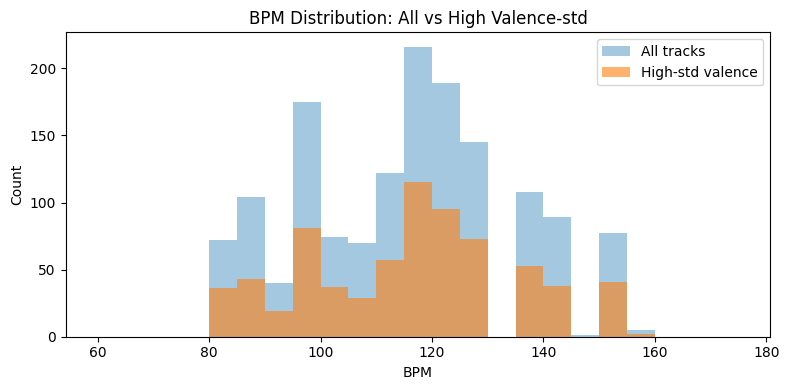

In [76]:
bins = range(60, 180, 5)

plt.figure(figsize=(8,4))
plt.hist(high_level['bpm'], bins=bins, alpha=0.4, label='All tracks')
plt.hist(high_level[high_level['valence_std']>thr]['bpm'], 
         bins=bins, alpha=0.6, label='High‑std valence')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.legend()
plt.title('BPM Distribution: All vs High Valence‑std')
plt.tight_layout()
plt.show()

/tmp/ipykernel_607/4186977281.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top5, notch=True)


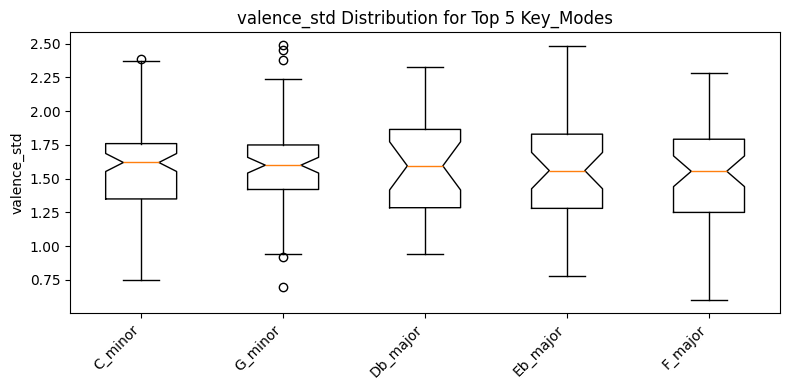

In [77]:
import numpy as np

top5 = top10.head(5).index.tolist()
data = [ high_level.loc[high_level['key_mode']==km, 'valence_std'] 
         for km in top5 ]

plt.figure(figsize=(8,4))
plt.boxplot(data, labels=top5, notch=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel('valence_std')
plt.title('valence_std Distribution for Top 5 Key_Modes')
plt.tight_layout()
plt.show()

In [78]:
from scipy.stats import spearmanr

# drop rows where either is NaN
df = high_level[['bpm','valence_std']].dropna()
if df['bpm'].nunique()>1 and df['valence_std'].nunique()>1:
    rho, p = spearmanr(df['bpm'], df['valence_std'])
    print(f"bpm vs valence_std: ρ={rho:.3f}, p={p:.3f}")
else:
    print("Not enough variance for spearmanr")

bpm vs valence_std: ρ=0.041, p=0.110


In [79]:
from scipy.stats import f_oneway

# pick top 6 modes by count to keep groups balanced
top_modes = high_level['key_mode'].value_counts().head(6).index
groups = [ high_level.loc[high_level['key_mode']==km,'valence_std'] 
           for km in top_modes ]

F, p = f_oneway(*groups)
print(f"ANOVA valence_std by key_mode: F={F:.2f}, p={p:.3f}")

ANOVA valence_std by key_mode: F=1.01, p=0.409


In [80]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# keep only rows with no missing bpm or key_mode
df = high_level[['bpm','key_mode','arousal_std']].dropna()

# define label
y = (df['arousal_std'] > df['arousal_std'].median()).astype(int)

# features
X_bpm = df[['bpm']].values
enc = OneHotEncoder(sparse_output=False)
X_km  = enc.fit_transform(df[['key_mode']])
X = np.hstack([StandardScaler().fit_transform(X_bpm), X_km])

model = LogisticRegression(max_iter=200)
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("AUC:", scores.mean())

model.fit(X, y)
coefs = model.coef_[0]

AUC: 0.4816626418329649


In [81]:
# feature names: ['bpm'] + encoder.categories_[0].tolist()

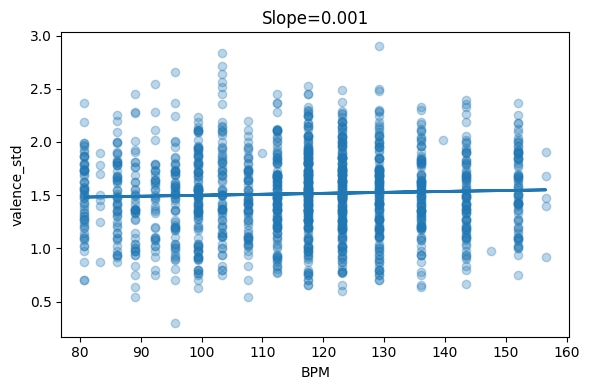

In [82]:
import numpy as np

df = high_level[['bpm','valence_std']].dropna()
x, y = df['bpm'].values, df['valence_std'].values
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.plot(x, m*x + b, lw=2)
plt.xlabel('BPM'); plt.ylabel('valence_std')
plt.title(f"Slope={m:.3f}")
plt.tight_layout()
plt.show()

In [83]:
import pandas as pd

# load
df = pd.read_parquet('df_high.parquet')

# prep
df['key_mode'] = df['key'].astype(str) + '_' + df['mode'].astype(str)
bins = range(int(df['bpm'].min()), int(df['bpm'].max())+10, 10)
df['bpm_bin'] = pd.cut(df['bpm'], bins)

# thresholds (example: median)
val_thresh = df['valence_mean'].median()
aro_thresh = df['arousal_mean'].median()

# helper to get normalized ratios
def top_normalized(col, thresh, feature, top_n=5):
    subset = df[df[col] > thresh]
    freq_high = subset[feature].value_counts()
    freq_tot  = df[feature].value_counts()
    ratio     = (freq_high / freq_tot).sort_values(ascending=False)
    return ratio.head(top_n)

# key_mode top for valence
print("Top key_modes for high valence:")
print(top_normalized('valence_mean', val_thresh, 'key_mode', top_n=7))

# key_mode top for arousal
print("\nTop key_modes for high arousal:")
print(top_normalized('arousal_mean', aro_thresh, 'key_mode', top_n=7))

# BPM-bin top for valence
print("\nTop BPM bins for high valence:")
print(top_normalized('valence_mean', val_thresh, 'bpm_bin', top_n=7))

# BPM-bin top for arousal
print("\nTop BPM bins for high arousal:")
print(top_normalized('arousal_mean', aro_thresh, 'bpm_bin', top_n=7))

Top key_modes for high valence:
key_mode
E_major     0.625000
Bb_minor    0.590909
D#_minor    0.571429
G_major     0.537879
A_minor     0.534247
A_major     0.518072
Ab_major    0.511628
Name: count, dtype: float64

Top key_modes for high arousal:
key_mode
C#_minor    0.625000
E_major     0.575000
A_minor     0.547945
Bb_minor    0.545455
C_minor     0.537634
Ab_major    0.534884
D#_minor    0.523810
Name: count, dtype: float64

Top BPM bins for high valence:
bpm_bin
(140, 150]    0.600000
(150, 160]    0.512195
(90, 100]     0.502326
(80, 90]      0.500000
(110, 120]    0.488166
(100, 110]    0.486111
(130, 140]    0.481481
Name: count, dtype: float64

Top BPM bins for high arousal:
bpm_bin
(140, 150]    0.566667
(130, 140]    0.537037
(150, 160]    0.512195
(120, 130]    0.505988
(80, 90]      0.500000
(110, 120]    0.467456
(100, 110]    0.451389
Name: count, dtype: float64


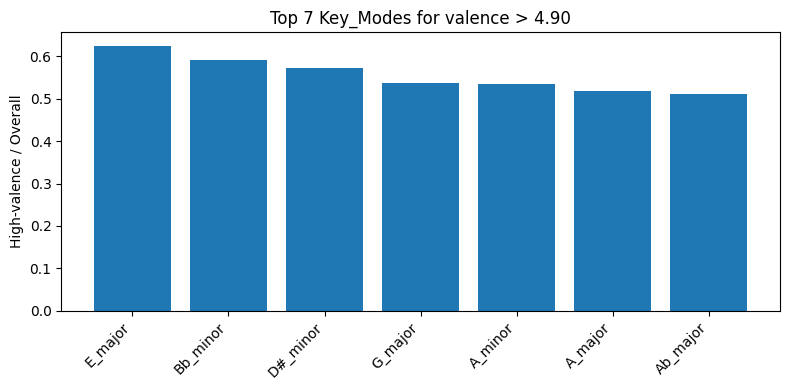

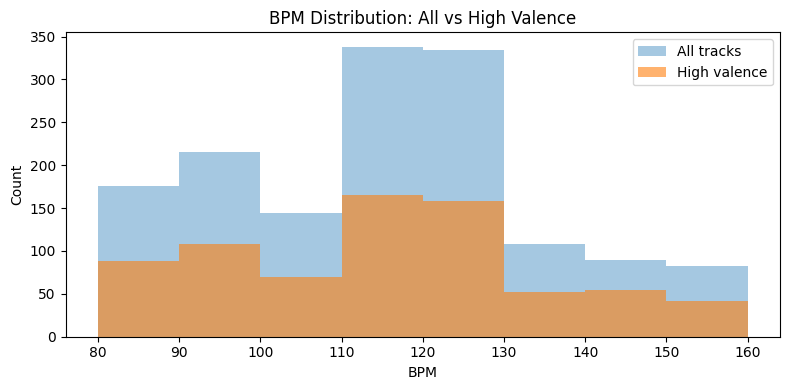

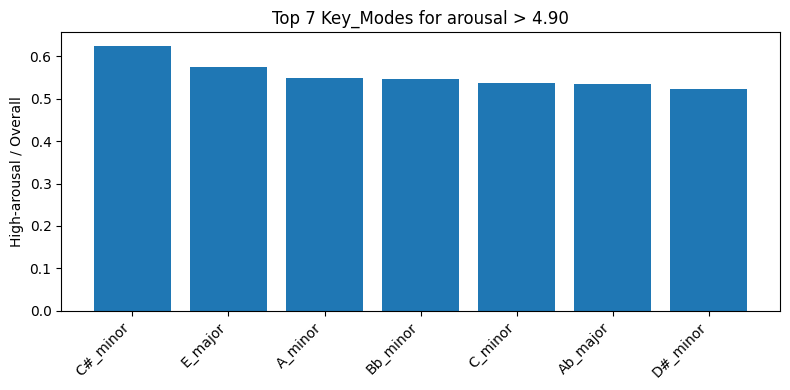

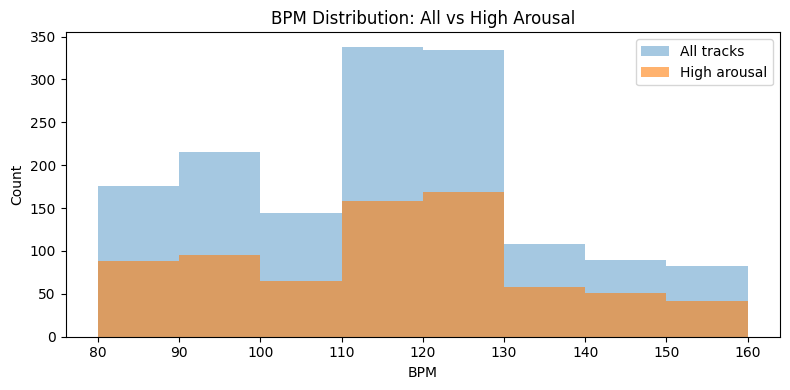

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_parquet('df_high.parquet')

# Precompute features
df['key_mode'] = df['key'].astype(str) + '_' + df['mode'].astype(str)
bins = range(int(df['bpm'].min()), int(df['bpm'].max()) + 10, 10)

# Thresholds on raw values
val_thresh = df['valence_mean'].median()
aro_thresh = df['arousal_mean'].median()

# Top key_modes by normalized ratio for valence
freq_high_val = df[df['valence_mean'] > val_thresh]['key_mode'].value_counts()
freq_tot = df['key_mode'].value_counts()
ratio_val = (freq_high_val / freq_tot).sort_values(ascending=False)
top7_km_val = ratio_val.head(7)

# Bar chart: key_modes for high valence
plt.figure(figsize=(8, 4))
plt.bar(top7_km_val.index, top7_km_val.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('High-valence / Overall')
plt.title(f'Top 7 Key_Modes for valence > {val_thresh:.2f}')
plt.tight_layout()
plt.show()

# Overlaid BPM histograms: valence
plt.figure(figsize=(8, 4))
plt.hist(df['bpm'], bins=bins, alpha=0.4, label='All tracks')
plt.hist(df[df['valence_mean'] > val_thresh]['bpm'], bins=bins, alpha=0.6, label='High valence')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.legend()
plt.title('BPM Distribution: All vs High Valence')
plt.tight_layout()
plt.show()

# Top key_modes by normalized ratio for arousal
freq_high_aro = df[df['arousal_mean'] > aro_thresh]['key_mode'].value_counts()
ratio_aro = (freq_high_aro / freq_tot).sort_values(ascending=False)
top7_km_aro = ratio_aro.head(7)

# Bar chart: key_modes for high arousal
plt.figure(figsize=(8, 4))
plt.bar(top7_km_aro.index, top7_km_aro.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('High-arousal / Overall')
plt.title(f'Top 7 Key_Modes for arousal > {aro_thresh:.2f}')
plt.tight_layout()
plt.show()

# Overlaid BPM histograms: arousal
plt.figure(figsize=(8, 4))
plt.hist(df['bpm'], bins=bins, alpha=0.4, label='All tracks')
plt.hist(df[df['arousal_mean'] > aro_thresh]['bpm'], bins=bins, alpha=0.6, label='High arousal')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.legend()
plt.title('BPM Distribution: All vs High Arousal')
plt.tight_layout()
plt.show()

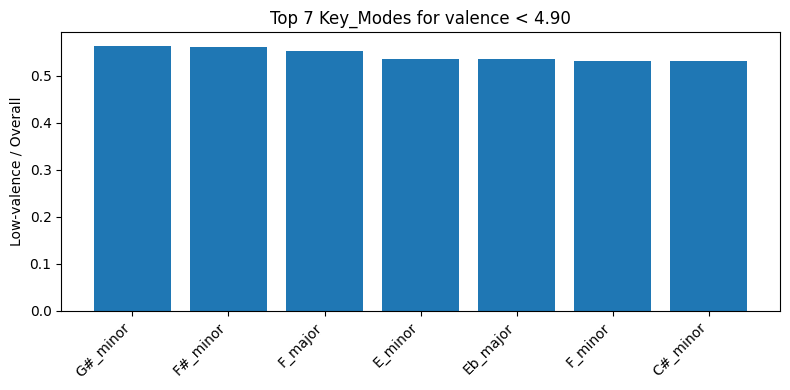

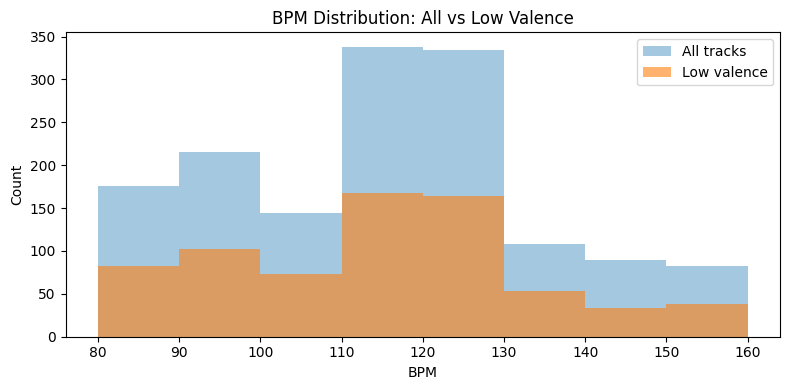

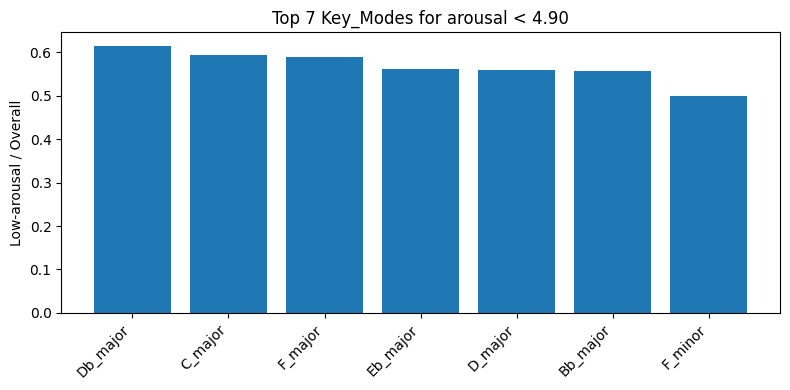

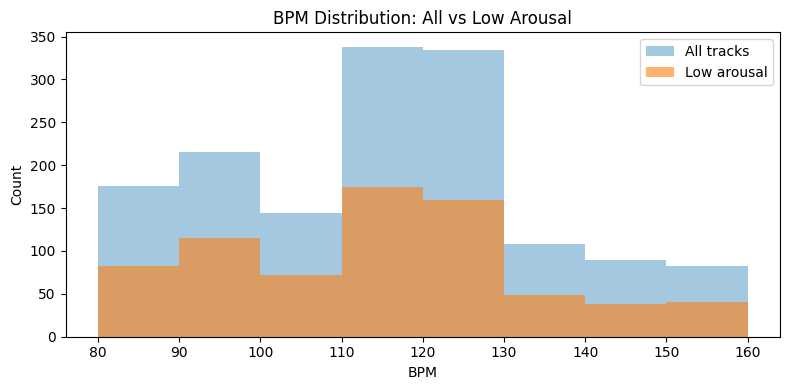

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# — Load your DataFrame (ensure you have a parquet engine installed) —
df = pd.read_parquet('df_high.parquet')

# — Prep features —
df['key_mode'] = df['key'].astype(str) + '_' + df['mode'].astype(str)
bins = range(int(df['bpm'].min()), int(df['bpm'].max()) + 10, 10)

# — Compute medians —
val_thresh = df['valence_mean'].median()
aro_thresh = df['arousal_mean'].median()

# — Low valence analysis —
freq_low_val = df[df['valence_mean'] < val_thresh]['key_mode'].value_counts()
ratio_low_val = (freq_low_val / df['key_mode'].value_counts()).sort_values(ascending=False)
top7_low_val = ratio_low_val.head(7)

plt.figure(figsize=(8,4))
plt.bar(top7_low_val.index, top7_low_val.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Low‑valence / Overall')
plt.title(f'Top 7 Key_Modes for valence < {val_thresh:.2f}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['bpm'], bins=bins, alpha=0.4, label='All tracks')
plt.hist(df[df['valence_mean'] < val_thresh]['bpm'], bins=bins,
         alpha=0.6, label='Low valence')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.legend()
plt.title('BPM Distribution: All vs Low Valence')
plt.tight_layout()
plt.show()


# — Low arousal analysis —
freq_low_aro = df[df['arousal_mean'] < aro_thresh]['key_mode'].value_counts()
ratio_low_aro = (freq_low_aro / df['key_mode'].value_counts()).sort_values(ascending=False)
top7_low_aro = ratio_low_aro.head(7)

plt.figure(figsize=(8,4))
plt.bar(top7_low_aro.index, top7_low_aro.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Low‑arousal / Overall')
plt.title(f'Top 7 Key_Modes for arousal < {aro_thresh:.2f}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['bpm'], bins=bins, alpha=0.4, label='All tracks')
plt.hist(df[df['arousal_mean'] < aro_thresh]['bpm'], bins=bins,
         alpha=0.6, label='Low arousal')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.legend()
plt.title('BPM Distribution: All vs Low Arousal')
plt.tight_layout()
plt.show()

In [86]:
mid_level_path = 'df_mid.parquet'
mid_level = pd.read_parquet(mid_level_path)

mid_valence_key_tracks = mid_level[mid_level['valence_std'] > val_std_mid]

In [87]:
mid_valence_key_tracks.columns

Index(['song_id', 'track_name', 'artist_name', 'valence_mean', 'arousal_mean',
       'valence_std', 'arousal_std', 'lyrics', 'pitch_stability',
       'voice_quality', 'harmonicity', 'timbre_brightness', 'timbre_richness',
       'timbre_texture', 'dynamics', 'rhythmic_activity', 'tonal_balance_low',
       'tonal_balance_mid', 'mfcc_formant', 'mfcc_spectral', 'mfcc_texture',
       'bpm', 'key', 'mode', 'key_confidence'],
      dtype='object')

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
mid_level.drop(['lyrics'], axis=columns)
corr_matrix = mid_level.corr()

# Visualize with a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Mid-Level Features")
plt.show()

# Identify highly correlated pairs
high_corr = [(col1, col2) for col1 in corr_matrix.columns 
             for col2 in corr_matrix.columns 
             if col1 < col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Highly correlated pairs:", high_corr)

TypeError: unhashable type: 'list'

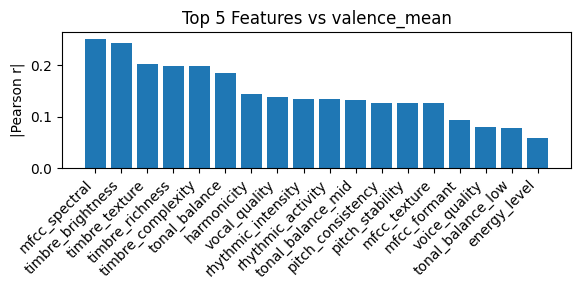

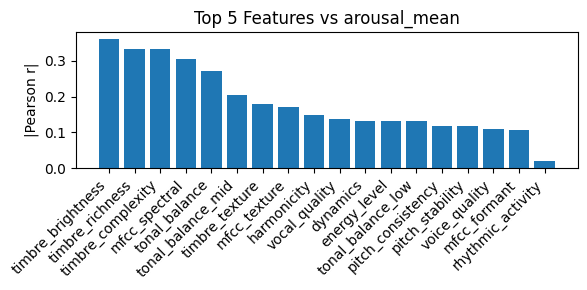

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and merge
mid = pd.read_parquet('df_mid.parquet')
high = pd.read_parquet('df_high.parquet')

combined = mid.merge(
    high[['song_id',
          'pitch_consistency',
          'vocal_quality',
          'timbre_complexity',
          'energy_level',
          'rhythmic_intensity',
          'tonal_balance']],
    on='song_id'
)

# 2. Select features
features = [
    # mid‑level
    'pitch_stability',
    'voice_quality',
    'harmonicity',
    'timbre_brightness',
    'timbre_richness',
    'timbre_texture',
    'dynamics',
    'rhythmic_activity',
    'tonal_balance_low',
    'tonal_balance_mid',
    'mfcc_formant',
    'mfcc_spectral',
    'mfcc_texture',
    'bpm',
    # high‑level
    'pitch_consistency',
    'vocal_quality',
    'timbre_complexity',
    'energy_level',
    'rhythmic_intensity',
    'tonal_balance'
]

# 3. Clean up
cols = features + ['valence_mean', 'arousal_mean']
df = combined[cols].dropna()

# 4. Correlations
corrs = df.corr()

# 5. Top 5 vs valence_mean
val_corr = corrs['valence_mean'] \
    .drop(['valence_mean','arousal_mean']) \
    .abs() \
    .sort_values(ascending=False).head(18)

# 6. Top 5 vs arousal_mean
aro_corr = corrs['arousal_mean'] \
    .drop(['valence_mean','arousal_mean']) \
    .abs() \
    .sort_values(ascending=False).head(18)

# 7. Plot
for target, top5 in [('valence_mean', val_corr), ('arousal_mean', aro_corr)]:
    plt.figure(figsize=(6,3))
    plt.bar(top5.index, top5.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('|Pearson r|')
    plt.title(f'Top 5 Features vs {target}')
    plt.tight_layout()
    plt.show()

In [42]:
mfcc_corr = corrs.filter(like='mfcc_').loc[['valence_mean','arousal_mean']]
print(mfcc_corr.abs().T.sort_values(by=['valence_mean','arousal_mean'], ascending=False).head(10))

               valence_mean  arousal_mean
mfcc_spectral      0.251824      0.304807
mfcc_texture       0.126497      0.170947
mfcc_formant       0.094187      0.105523


In [43]:
from sklearn.linear_model import RidgeCV
X = df[ ['timbre_brightness','timbre_richness','timbre_texture'] ]
y = df['valence_mean']
model = RidgeCV(alphas=[0.1,1,10]).fit(X, y)
print(model.coef_)

[ 7.77374711e-04 -6.60074875e-08 -5.68187125e-04]


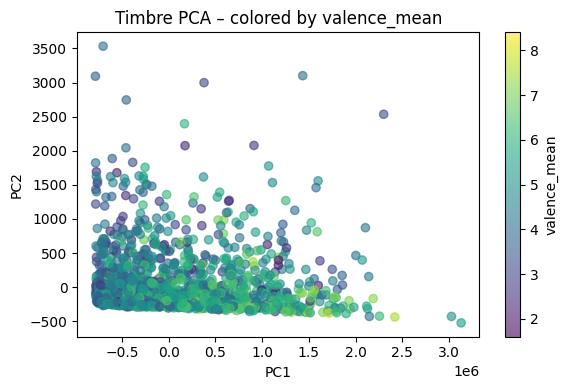

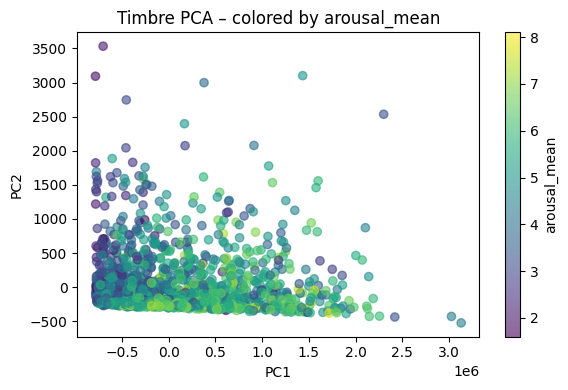

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Load merged DataFrame (mid + high levels)
df = pd.read_parquet('df_mid.parquet') \
       .merge(
         pd.read_parquet('df_high.parquet')[
           ['song_id','timbre_complexity','vocal_quality','pitch_consistency']
         ],
         on='song_id'
       )

# 2. Define timbre feature list
timbre_feats = [
  'timbre_brightness',
  'timbre_richness',
  'timbre_texture',
  'timbre_complexity'
]

# 3. Subset and drop NaNs
df_t = df[timbre_feats + ['valence_mean','arousal_mean']].dropna()

# 4. Fit PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(df_t[timbre_feats])

# 5. Create PCs DataFrame
pc_df = pd.DataFrame(
  pcs, columns=['PC1','PC2'], index=df_t.index
)
pc_df['valence_mean'] = df_t['valence_mean']
pc_df['arousal_mean'] = df_t['arousal_mean']

# 6a. Scatter: colored by valence_mean
plt.figure(figsize=(6,4))
plt.scatter(pc_df['PC1'], pc_df['PC2'],
            c=pc_df['valence_mean'], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Timbre PCA – colored by valence_mean')
plt.colorbar(label='valence_mean')
plt.tight_layout()
plt.show()

# 6b. Scatter: colored by arousal_mean
plt.figure(figsize=(6,4))
plt.scatter(pc_df['PC1'], pc_df['PC2'],
            c=pc_df['arousal_mean'], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Timbre PCA – colored by arousal_mean')
plt.colorbar(label='arousal_mean')
plt.tight_layout()
plt.show()

Using timbre features: ['pcm_fftMag_spectralRollOff25.0_sma_amean_mean', 'pcm_fftMag_spectralRollOff50.0_sma_amean_mean', 'pcm_fftMag_spectralRollOff75.0_sma_amean_mean', 'pcm_fftMag_spectralRollOff90.0_sma_amean_mean', 'pcm_fftMag_spectralCentroid_sma_amean_mean', 'pcm_fftMag_spectralEntropy_sma_amean_mean', 'pcm_fftMag_spectralVariance_sma_amean_mean', 'pcm_fftMag_spectralRollOff25.0_sma_de_amean_mean', 'pcm_fftMag_spectralRollOff50.0_sma_de_amean_mean', 'pcm_fftMag_spectralRollOff75.0_sma_de_amean_mean', 'pcm_fftMag_spectralRollOff90.0_sma_de_amean_mean', 'pcm_fftMag_spectralCentroid_sma_de_amean_mean', 'pcm_fftMag_spectralEntropy_sma_de_amean_mean', 'pcm_fftMag_spectralVariance_sma_de_amean_mean']


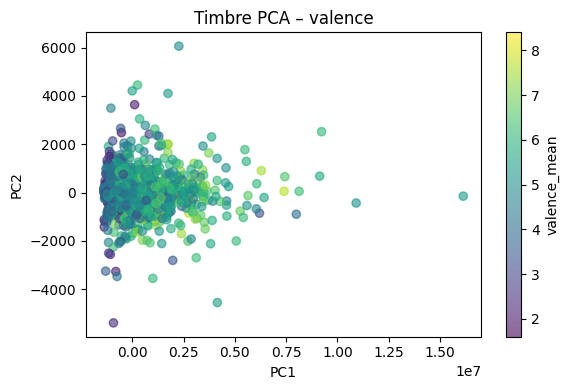

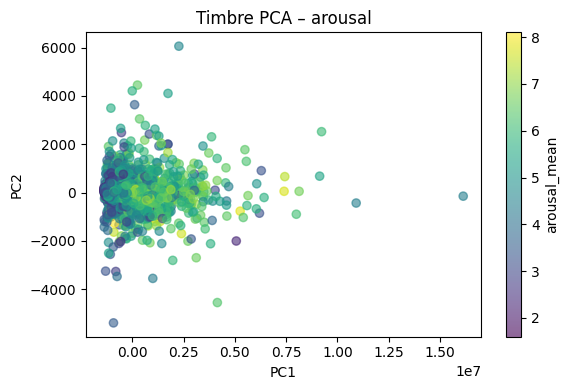

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) Load tables
high = pd.read_parquet('df_high.parquet')[['song_id','valence_mean','arousal_mean']]
mid  = pd.read_parquet('df_mid.parquet')
low  = pd.read_parquet('df_low.parquet')

# 2) Subset mid to drop any valence/arousal or text columns
drop_mid = {
    'valence_mean','arousal_mean',
    'valence_std','arousal_std',
    'lyrics','track_name','artist_name'
}
mid_feats = ['song_id'] + [c for c in mid.columns
                           if c not in drop_mid and c != 'song_id']

# 3) Detect spectral‐timbre low‐level columns
timbre_feats = [
    c for c in low.columns
    if any(x in c for x in ('spectralCentroid','RollOff','spectralEntropy','spectralVariance'))
    and c.endswith('_amean_mean')
]
print("Using timbre features:", timbre_feats)

# 4) Merge in order: high → mid → low
df = (
    high
    .merge(mid[mid_feats], on='song_id')
    .merge(low[['song_id'] + timbre_feats], on='song_id')
)

# 5) Drop any rows missing required columns
required = ['valence_mean','arousal_mean'] + timbre_feats
df = df.dropna(subset=required)

# 6) PCA on timbre_feats
pca = PCA(n_components=2)
pcs = pca.fit_transform(df[timbre_feats])

# 7) Prepare for plotting
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'], index=df.index)
pc_df['valence']  = df['valence_mean']
pc_df['arousal']  = df['arousal_mean']

# 8a) Plot PC colored by valence
plt.figure(figsize=(6,4))
plt.scatter(pc_df.PC1, pc_df.PC2, c=pc_df.valence, alpha=0.6)
plt.colorbar(label='valence_mean')
plt.title('Timbre PCA – valence')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# 8b) Plot PC colored by arousal
plt.figure(figsize=(6,4))
plt.scatter(pc_df.PC1, pc_df.PC2, c=pc_df.arousal, alpha=0.6)
plt.colorbar(label='arousal_mean')
plt.title('Timbre PCA – arousal')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [51]:
print("Explained variance ratios:", pca.explained_variance_ratio_)

Explained variance ratios: [9.99999523e-01 2.44754127e-07]


Top contributors to PC1:
 pcm_fftMag_spectralVariance_sma_amean_mean       1.000000
pcm_fftMag_spectralRollOff90.0_sma_amean_mean    0.000555
pcm_fftMag_spectralRollOff75.0_sma_amean_mean    0.000279
pcm_fftMag_spectralCentroid_sma_amean_mean       0.000214
pcm_fftMag_spectralRollOff50.0_sma_amean_mean    0.000114
dtype: float64


/tmp/ipykernel_607/381610257.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


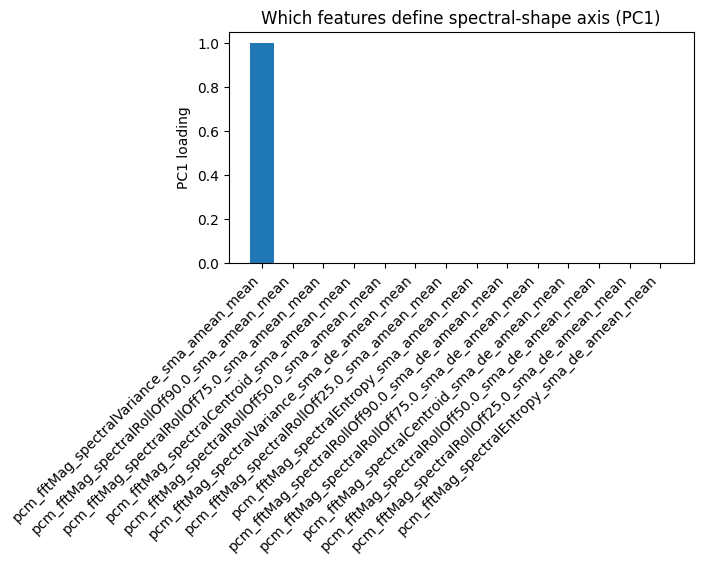

In [52]:
import pandas as pd
loadings = pd.Series(
    pca.components_[0],
    index=timbre_feats
).sort_values(key=abs, ascending=False)
print("Top contributors to PC1:\n", loadings.head(5))

# Bar‐plot loadings for PC1
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.bar(loadings.index, loadings.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("PC1 loading")
plt.title("Which features define spectral‐shape axis (PC1)")
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1) Load tables
high = pd.read_parquet('df_high.parquet')[['song_id','valence_mean','arousal_mean']]
low  = pd.read_parquet('df_low.parquet')

# 2) Merge labels onto low‐level features
df = high.merge(low, on='song_id')

# 3) Define your feature groups (adjust patterns as needed)
groups = {
    'spectral_shape': [
        'spectralCentroid', 'RollOff', 'spectralEntropy', 'spectralVariance'
    ],
    'rhythmic_complexity': [
        'spectralFlux', 'zcr', 'audspec_lengthL1norm', 'audspecRasta_lengthL1norm'
    ],
    'dynamics': [
        'RMSenergy', 'audspec_lengthL1norm', 'audspecRasta_lengthL1norm'
    ],
    'voice_quality': [
        'jitterLocal', 'shimmerLocal', 'logHNR'
    ]
}

# 4) Iterate groups, run PCA(1), report loadings & explained variance
results = {}

for name, pats in groups.items():
    # auto‐detect columns ending with "_amean_mean" or "_stddev_mean"
    cols = [
        c for c in df.columns
        if any(p in c for p in pats)
           and (c.endswith('_amean_mean') or c.endswith('_stddev_mean'))
    ]
    if not cols:
        print(f"⚠️  No columns found for group '{name}'")
        continue

    # subset & drop missing
    sub = df[cols].dropna()
    X = StandardScaler().fit_transform(sub)

    # PCA → 1 component
    pca = PCA(n_components=1)
    pca.fit(X)

    # loadings on original (after scaling)
    loadings = pd.Series(
        pca.components_[0],
        index=cols
    ).abs().sort_values(ascending=False)

    # explained variance
    ev = pca.explained_variance_ratio_[0]

    # correlation with valence/arousal
    pc1 = pca.transform(X).ravel()
    rho_val = pd.Series(pc1).corr(sub.assign(pc1=pc1)['pc1'])  # ≈1.0 by construction
    # instead correlate raw PC1 with valence/arousal
    df_pc = sub.copy()
    df_pc['pc1'] = pc1
    df_pc['val'] = df.loc[sub.index, 'valence_mean']
    df_pc['aro'] = df.loc[sub.index, 'arousal_mean']
    corr_val = df_pc['pc1'].corr(df_pc['val'])
    corr_aro = df_pc['pc1'].corr(df_pc['aro'])

    # store
    results[name] = {
        'cols': cols,
        'explained_variance': ev,
        'loadings': loadings,
        'corr_valence': corr_val,
        'corr_arousal': corr_aro
    }

# 5) Display summary
for name, res in results.items():
    print(f"\nGroup: {name}")
    print(f" Explained variance (PC1): {res['explained_variance']:.3f}")
    print(" Top loadings:")
    print(res['loadings'].head(5))
    print(f" Corr(PC1, valence): {res['corr_valence']:.3f}")
    print(f" Corr(PC1, arousal): {res['corr_arousal']:.3f}")

MergeError: Passing 'suffixes' which cause duplicate columns {'arousal_mean_y', 'valence_mean_y'} is not allowed.